This notebook serves as a second part of the **case1.ipynb** notebook. Here we run the same experimento several times, with different train/test splits, in order to test the average results obtained. We do this to test if a preprocessing step manages to improve the model's result with some statistical significance. In the **case1.ipynb** notebook we tested a single train/test split, and some of the results we observed might not hold for different splits. Maybe we just got lucky with our train/test split. To avoid these pitfalls, we will try each experiment several times and record the average behavior.

# 0 - Defining Basic Functionalities

The next cell contains several helper functions that will be used throughout this notebook. Here we create some functions for training a model and assessing its performance in a test set. We also create functions for encoding the data using the **dataprocessing** library. Some functions are tailored specifically for the dataset used here and won't generalize to other datasets.

In [1]:
import pandas as pd
import numpy as np
import uci_dataset as database
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import raimitigations.dataprocessing as dp

N_EXEC = 100

USE_AUC_TH = True

RESULT_KEYS = ["roc", "pr", "rc", "f1"]
COL_METRIC = "Metric"
COL_VALUE = "Value"
COL_TEST = "Test Case"

SEQ_FWD = 0
SEQ_BWD = 1
CATBOOST = 2

# -----------------------------------
def get_encoders(df):
	age_order = df['age'].unique()
	age_order.sort()
	tumor_size_order = df['tumor-size'].unique()
	tumor_size_order.sort()
	inv_nodes_order = df['inv-nodes'].unique()
	inv_nodes_order.sort()

	# Encode 'tumor-size', and 'inv-nodes' using ordinal encoding
	enc_ord = dp.EncoderOrdinal(col_encode=["age", "tumor-size", "inv-nodes"],
								categories={"age":age_order,
											"tumor-size":tumor_size_order, 
											"inv-nodes":inv_nodes_order},
								verbose=False
							)
	enc_ohe = dp.EncoderOHE(drop=False, unknown_err=False, verbose=False)
	return enc_ord, enc_ohe

# -----------------------------------
def encode_case1(df):
	enc_ord, enc_ohe = get_encoders(df)
	enc_ord.fit(df)
	proc_df = enc_ord.transform(df)

	# Encode the remaining categorical columns using One-Hot Encoding
	enc_ohe.fit(proc_df)
	proc_df = enc_ohe.transform(proc_df)
	return proc_df


# -----------------------------------
def encode_case1_train_test(train_x, test_x):
	enc_ord, enc_ohe = get_encoders(df)
	enc_ord.fit(train_x)
	train_x_enc = enc_ord.transform(train_x)
	test_x_enc = enc_ord.transform(test_x)

	enc_ohe.fit(train_x_enc)
	train_x_enc = enc_ohe.transform(train_x_enc)
	test_x_enc = enc_ohe.transform(test_x_enc)
	return train_x_enc, test_x_enc


# -----------------------------------
def impute_case1(df):
	imputer = dp.BasicImputer(verbose=False)
	imputer.fit(df)
	proc_df = imputer.transform(df)
	return proc_df


# -----------------------------------
def impute_case1_train_test(train_x, test_x):
	imputer = dp.BasicImputer(verbose=False)
	imputer.fit(train_x)
	train_x_enc = imputer.transform(train_x)
	test_x_enc = imputer.transform(test_x)
	return train_x_enc, test_x_enc


# -----------------------------------
def remove_corr_feat(df, label_col):
	cor_feat = dp.CorrelatedFeatures(
					method_num_num=["spearman", "pearson", "kendall"],				# Used for Numerical x Numerical correlations
					num_corr_th=0.9,												# Used for Numerical x Numerical correlations
					num_pvalue_th=0.05,												# Used for Numerical x Numerical correlations
					method_num_cat="model",											# Used for Numerical x Categorical correlations
					model_metrics=["f1", "auc"],									# Used for Numerical x Categorical correlations
					metric_th=0.9,													# Used for Numerical x Categorical correlations
					cat_corr_th=0.9,												# Used for Categorical x Categorical correlations
					cat_pvalue_th=0.01,												# Used for Categorical x Categorical correlations
					save_json=False,
					verbose=False
				)
	cor_feat.fit(df=df, label_col=label_col)
	proc_df = cor_feat.transform(df)
	return proc_df

# -----------------------------------
def feature_selection(train_x, train_y, test_x, feat_sel_type):
	if feat_sel_type == SEQ_FWD:
		feat_sel = dp.SeqFeatSelection(forward=True, n_jobs=4, verbose=False)
	elif feat_sel_type == SEQ_BWD:
		feat_sel = dp.SeqFeatSelection(forward=False, n_jobs=4, verbose=False)
	else:
		feat_sel = dp.CatBoostSelection(verbose=False)
	feat_sel.fit(X=train_x, y=train_y)
	train_x_sel = feat_sel.transform(train_x)
	test_x_sel = feat_sel.transform(test_x)

	features = feat_sel.get_selected_features()
	return train_x_sel, test_x_sel

# -----------------------------------
def artificial_smote(train_x, train_y, strategy, under_sample):
	rebalance = dp.Rebalance(
				X=train_x,
				y=train_y,
				strategy_over=strategy,
				over_sampler=True,
				under_sampler=under_sample,
				verbose=False
			)
	train_x_res, train_y_res = rebalance.fit_resample()
	return train_x_res, train_y_res

# -----------------------------------
def artificial_ctgan(train_x, train_y, strategy, savefile):
	synth = dp.Synthesizer(
				X=train_x,
				y=train_y,
				epochs=400,
				model="ctgan",
				load_existing=True,
				save_file=savefile,
				verbose=False
			)
	synth.fit()
	syn_train_x, syn_train_y = synth.transform(X=train_x, y=train_y, strategy=strategy)
	return syn_train_x, syn_train_y

# -----------------------------------
# -----------------------------------
# -----------------------------------
def result_statistics(result_list):
	result_stat = {}
	for result in result_list:
		for key in RESULT_KEYS:
			if key in result_stat.keys():
				result_stat[key].append(result[key])
			else:
				result_stat[key] = [result[key]]

	return result_stat


# -----------------------------------
def add_results_df(result_df, result_stat, test_name):
	col_test = []
	col_metric = []
	col_value = []
	for metric in RESULT_KEYS:
		col_value += result_stat[metric]
		col_test += [test_name for _ in range(len(result_stat[metric]))]
		col_metric += [metric for _ in range(len(result_stat[metric]))]

	new_df = pd.DataFrame()
	new_df[COL_VALUE] = col_value
	new_df[COL_TEST] = col_test
	new_df[COL_METRIC] = col_metric
	new_df[COL_VALUE] = new_df[COL_VALUE].apply(float)

	if result_df is None:
		return new_df
	
	result_df = pd.concat([result_df, new_df], axis=0)
	
	return result_df


# -----------------------------------
def test_base(df, label_col, n_exec, model_name):
	result_list = []
	proc_df = encode_case1(df)
	proc_df = impute_case1(proc_df)
	for n in range(n_exec):
		train_x, test_x, train_y, test_y = dp.split_data(proc_df, label_col, test_size=0.25)
		result = dp.train_model_fetch_results(train_x, train_y, test_x, test_y, model_name, USE_AUC_TH)
		result_list.append(result)

	result_stat = result_statistics(result_list)

	return result_stat


# -----------------------------------
def test_corr(df, label_col, n_exec, model_name):
	result_list = []
	proc_df = remove_corr_feat(df, label_col)
	proc_df = encode_case1(proc_df)
	proc_df = impute_case1(proc_df)
	for n in range(n_exec):
		train_x, test_x, train_y, test_y = dp.split_data(proc_df, label_col, test_size=0.25)
		result = dp.train_model_fetch_results(train_x, train_y, test_x, test_y, model_name, USE_AUC_TH)
		result_list.append(result)

	result_stat = result_statistics(result_list)

	return result_stat

# -----------------------------------
def test_smote(df, label_col, n_exec, model_name, rcorr=True, feat_sel_type=None, art_str=None, under=False):
	result_list = []
	proc_df = df
	if rcorr:
		proc_df = remove_corr_feat(proc_df, label_col)
	proc_df = encode_case1(proc_df)
	proc_df = impute_case1(proc_df)
	for n in range(n_exec):
		train_x, test_x, train_y, test_y = dp.split_data(proc_df, label_col, test_size=0.25)
		if art_str is not None:
			train_x, train_y = artificial_smote(train_x, train_y, art_str, under)
		if feat_sel_type is not None:
			train_x, test_x = feature_selection(train_x, train_y, test_x, feat_sel_type)
		result = dp.train_model_fetch_results(train_x, train_y, test_x, test_y, model_name, USE_AUC_TH)
		result_list.append(result)

	result_stat = result_statistics(result_list)

	return result_stat



# -----------------------------------
def test_ctgan_first(df, label_col, n_exec, model_name, rcorr=True, feat_sel_type=None, art_str=None, savefile=None):
	result_list = []
	proc_df = df
	if rcorr:
		proc_df = remove_corr_feat(proc_df, label_col)
	for n in range(n_exec):
		train_x, test_x, train_y, test_y = dp.split_data(proc_df, label_col, test_size=0.25)
		if art_str is not None:
			train_x, train_y = artificial_ctgan(train_x, train_y, art_str, savefile)
		train_x, test_x = encode_case1_train_test(train_x, test_x)
		train_x, test_x = impute_case1_train_test(train_x, test_x)
		if feat_sel_type is not None:
			train_x, test_x = feature_selection(train_x, train_y, test_x, feat_sel_type)
		result = dp.train_model_fetch_results(train_x, train_y, test_x, test_y, model_name, USE_AUC_TH)
		result_list.append(result)

	result_stat = result_statistics(result_list)

	return result_stat

# -----------------------------------
# -----------------------------------
# -----------------------------------
def plot_results(res_df, y_lim=[0.5, 0.75]):
	plt.figure().clear()
	plt.close()
	plt.cla()
	plt.clf()

	fig = plt.gcf()
	fig.set_size_inches(18, 10)
	#fig.set_dpi(100)

	sns.set_theme(style="whitegrid")
	plt.ylim(y_lim[0], y_lim[1])
	ax = sns.barplot(x=COL_METRIC, y=COL_VALUE, hue=COL_TEST, data=res_df)
	plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize=20)
	#ax.axes.set_title("Title",fontsize=50)
	ax.set_xlabel(COL_METRIC, fontsize=30)
	ax.set_ylabel(COL_VALUE, fontsize=30)
	ax.tick_params(labelsize=15)
	plt.show()

# 1 - Understanding the Data

In [2]:
df = database.load_breast_cancer()
label_col = "Class"
df[label_col] = df[label_col].replace({"recurrence-events": 1, "no-recurrence-events": 0})
df

,Class,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat
0,0,30-39,premeno,30-34,0-2,no,3,left,left_low,no
1,0,40-49,premeno,20-24,0-2,no,2,right,right_up,no
2,0,40-49,premeno,20-24,0-2,no,2,left,left_low,no
3,0,60-69,ge40,15-19,0-2,no,2,right,left_up,no
4,0,40-49,premeno,0-4,0-2,no,2,right,right_low,no
...,...,...,...,...,...,...,...,...,...,...
281,1,30-39,premeno,30-34,0-2,no,2,left,left_up,no
282,1,30-39,premeno,20-24,0-2,no,3,left,left_up,yes
283,1,60-69,ge40,20-24,0-2,no,1,right,left_up,no
284,1,40-49,ge40,30-34,3-5,no,3,left,left_low,no


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286 entries, 0 to 285
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Class        286 non-null    int64 
 1   age          286 non-null    object
 2   menopause    286 non-null    object
 3   tumor-size   286 non-null    object
 4   inv-nodes    286 non-null    object
 5   node-caps    278 non-null    object
 6   deg-malig    286 non-null    int64 
 7   breast       286 non-null    object
 8   breast-quad  285 non-null    object
 9   irradiat     286 non-null    object
dtypes: int64(2), object(8)
memory usage: 22.5+ KB


# 2 - Efficiency of Different Classes from raimitigations.dataprocessing lib

In this section we will test different preprocessing classes provided by the **dataprocessing** class. We will always compare the model's performance when trained with the original dataset and when trained with a preprocessed dataset. Note that, as previously mentioned, for each different version of the dataset used (with different preprocessing steps), we train different versions of the same model using different train/test splits and then record the mean and standard deviation of the observed metrics (ROC AUC, Precision, Recall, and F1 score).

## KNN Model

Let's start by fixing the learning algorithm/model to be the K-Nearest Neighbors (KNN).

### Feature Selection

Here we compare 4 training pipelines, all of them using the KNN model, as previously mentioned:
- Baseline dataset (only encoding and imputation applied)
- Baseline dataset + removal of highly correlated features (using the **CorrelatedFeatures** class)
- Baseline dataset + feature selection using Sequential Backward Selection (using the **SeqFeatSelection** class)
- Baseline dataset + feature selection using the CatBoost model feature weights (using the **CatBoostSelection** class).

In [11]:
MODEL_NAME = "knn"

result_base = test_base(df, label_col, N_EXEC, MODEL_NAME)
result_df = add_results_df(None, result_base, "Baseline")

result_cor = test_corr(df, label_col, N_EXEC, MODEL_NAME)
result_df = add_results_df(result_df, result_cor, "Corr.")

restult_fs = test_smote(df, label_col, N_EXEC, MODEL_NAME, rcorr=False, feat_sel_type=SEQ_BWD)
result_df = add_results_df(result_df, restult_fs, "Seq.Bwd.")

restult_fs = test_smote(df, label_col, N_EXEC, MODEL_NAME, rcorr=False, feat_sel_type=CATBOOST)
result_df = add_results_df(result_df, restult_fs, "CatBoost")

../../errorsmitigation/dataprocessing/utils_model.py:65: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
../../errorsmitigation/dataprocessing/utils_model.py:65: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
../../errorsmitigation/dataprocessing/utils_model.py:65: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
../../errorsmitigation/dataprocessing/utils_model.py:65: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
../../errorsmitigation/dataprocessing/utils_model.py:65: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
../../errorsmitigation/dataprocessing/utils_model.py:65: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * preci

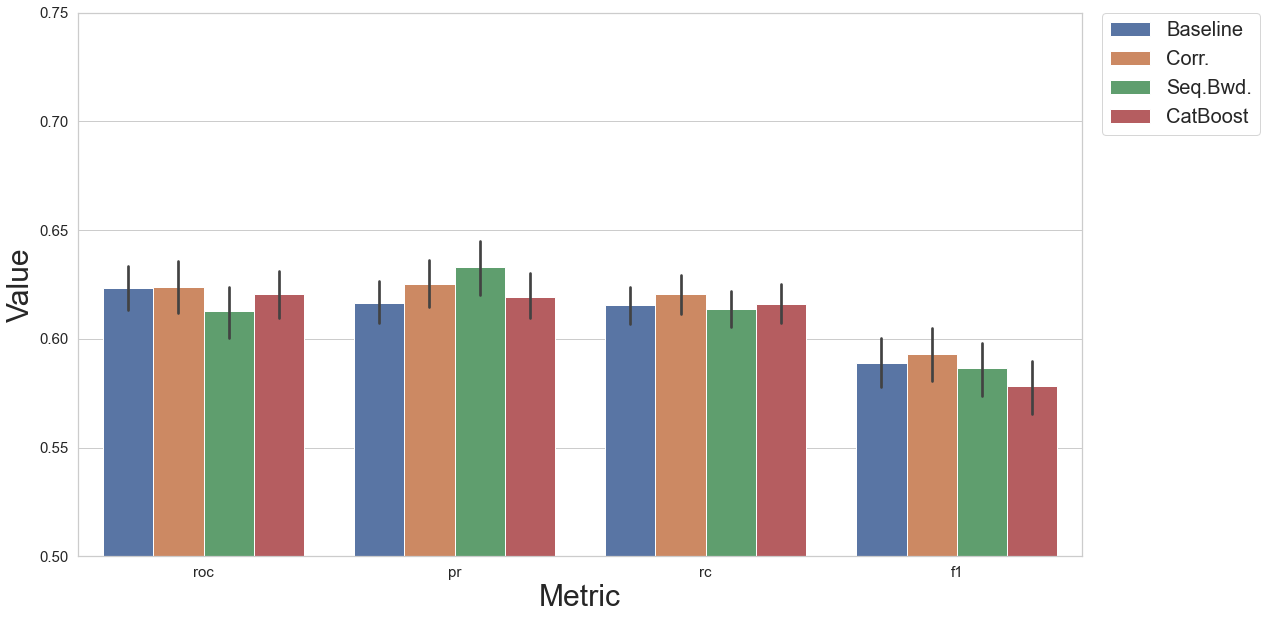

In [12]:
plot_results(result_df)

Some important observations regarding the above graph:
- It seems that by removing highly correlated features (orange bar) results in slightly better results. However, if we check the list of pairs of correlated features in this dataset (check the JSON file **corr_json/c1_corr.json**), we can see that there are none. This means that no features were removed using **CorrelatedFeatures** class, which means that the orange results were generated by the exact same steps as the blue one (baseline). The increased F1 score for the orange experiment is a mere coincidence. This is also expected, since the standard deviation error is relatively high (the small black lines on top of each bar). The high standard deviation is also expected because of the small size of the dataset, which makes the train/test split even more important;
- The other two feature selection experiments (green and red bars) didn't provide any improvements with a statistical significance.

### Artificial Instances - SMOTE

The next set of experiments aims to test the efficiency of the SMOTE and TOMEK Links (over and under sampling, respectively). Here we perform 3 experiments:
- Baseline dataset (only encoding and imputation applied)
- Baseline dataset + over sampling (using the **Rebalance** class)
- Baseline dataset + over and under sampling (using the **Rebalance** class).

In [ ]:
MODEL_NAME = "knn"
result_base = test_base(df, label_col, N_EXEC, MODEL_NAME)
result_df = add_results_df(None, result_base, "Baseline")

restult_fs = test_smote(df, label_col, N_EXEC, MODEL_NAME, rcorr=True, art_str=0.7, under=False)
result_df = add_results_df(result_df, restult_fs, "SM")

restult_fs = test_smote(df, label_col, N_EXEC, MODEL_NAME, rcorr=True, art_str=0.7, under=True)
result_df = add_results_df(result_df, restult_fs, "SM+TK")

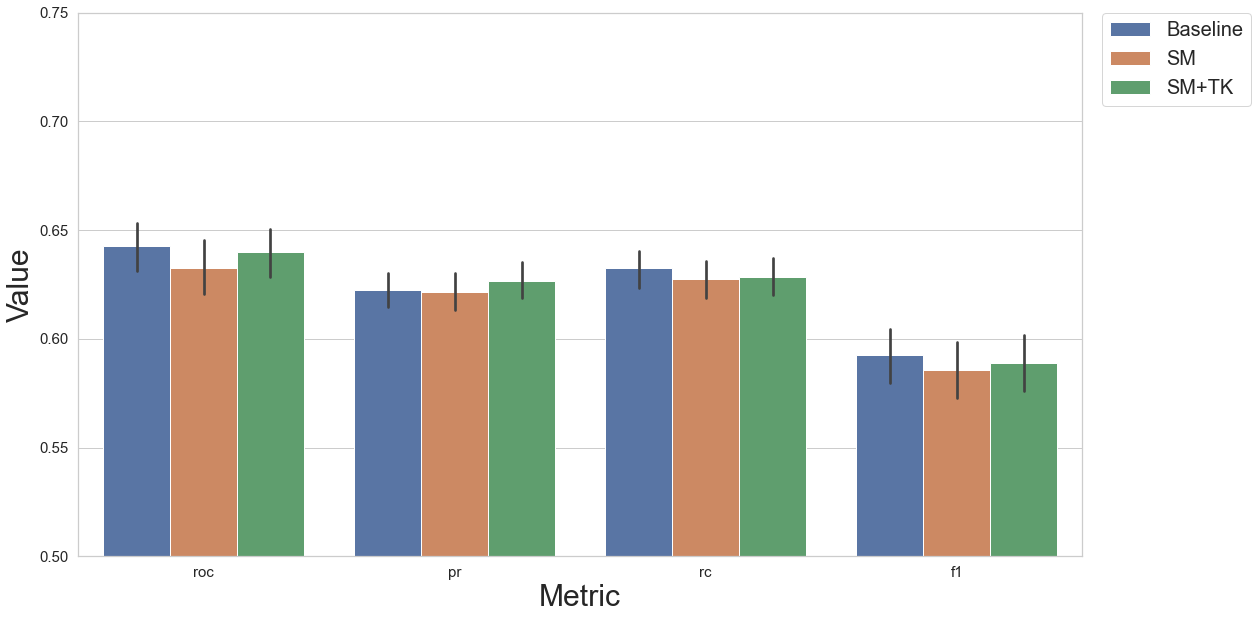

In [ ]:
plot_results(result_df)

### Artificial Instances - CTGAN

Instead of doing over sampling using SMOTE and its variations, we can create artificial instances of the minority class using the CTGAN. Here we perform 3 experiments:
- Baseline dataset (only encoding and imputation applied)
- Baseline dataset + over sampling with CTGAN (using the **Synthesizer** class) with a minority/majority ration of 0.6
- Baseline dataset + over sampling with CTGAN (using the **Synthesizer** class) with a minority/majority ration of 0.9

In [ ]:
MODEL_NAME = "knn"
result_base = test_base(df, label_col, N_EXEC, MODEL_NAME)
result_df = add_results_df(None, result_base, "Baseline")

restult_fs = test_ctgan_first(df, label_col, N_EXEC, MODEL_NAME, rcorr=False, feat_sel_type=None, art_str=0.6, savefile="1_1.pkl")
result_df = add_results_df(result_df, restult_fs, "CTGAN 0.6")

restult_fs = test_ctgan_first(df, label_col, N_EXEC, MODEL_NAME, rcorr=False, feat_sel_type=None, art_str=0.9, savefile="1_2.pkl")
result_df = add_results_df(result_df, restult_fs, "CTGAN 0.9")


/home/matheus/miniconda3/envs/resp/lib/python3.7/site-packages/sklearn/mixture/_base.py:146: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  .fit(X)


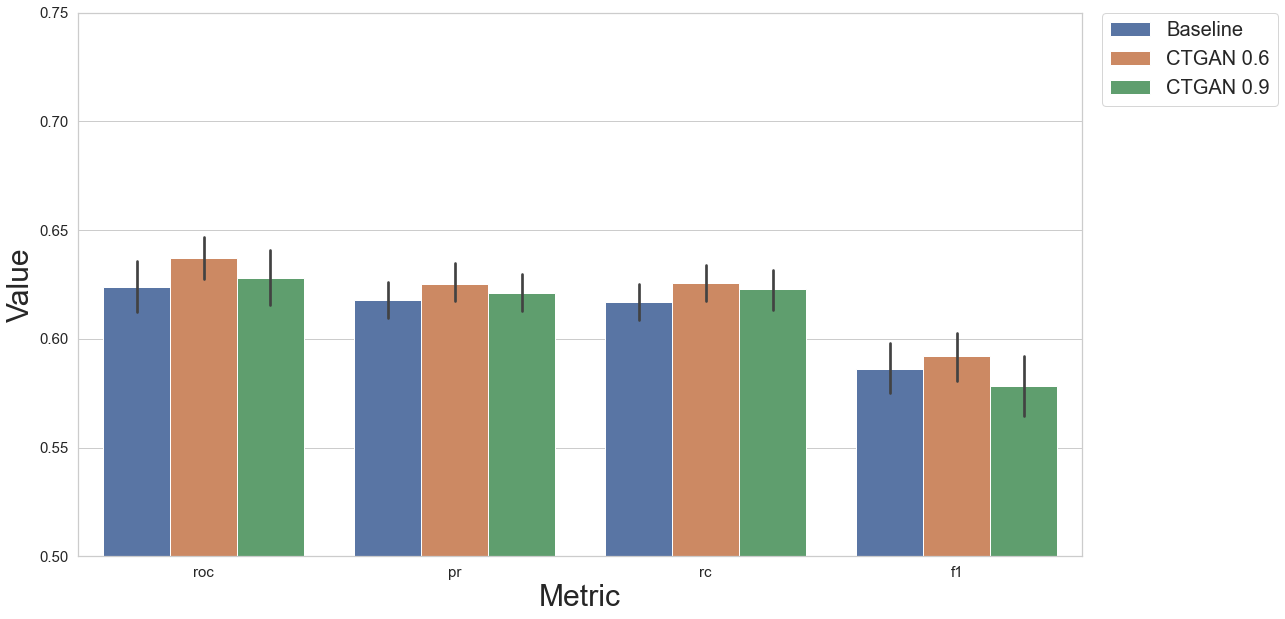

In [ ]:
plot_results(result_df)

## XGBoost

### Feature Selection

In [ ]:
MODEL_NAME = "xgb"

result_base = test_base(df, label_col, N_EXEC, MODEL_NAME)
result_df = add_results_df(None, result_base, "Baseline")

result_cor = test_corr(df, label_col, N_EXEC, MODEL_NAME)
result_df = add_results_df(result_df, result_cor, "Corr.")

restult_fs = test_smote(df, label_col, N_EXEC, MODEL_NAME, rcorr=False, feat_sel_type=SEQ_BWD)
result_df = add_results_df(result_df, restult_fs, "Seq.Bwd.")

restult_fs = test_smote(df, label_col, N_EXEC, MODEL_NAME, rcorr=False, feat_sel_type=CATBOOST)
result_df = add_results_df(result_df, restult_fs, "CatBoost")

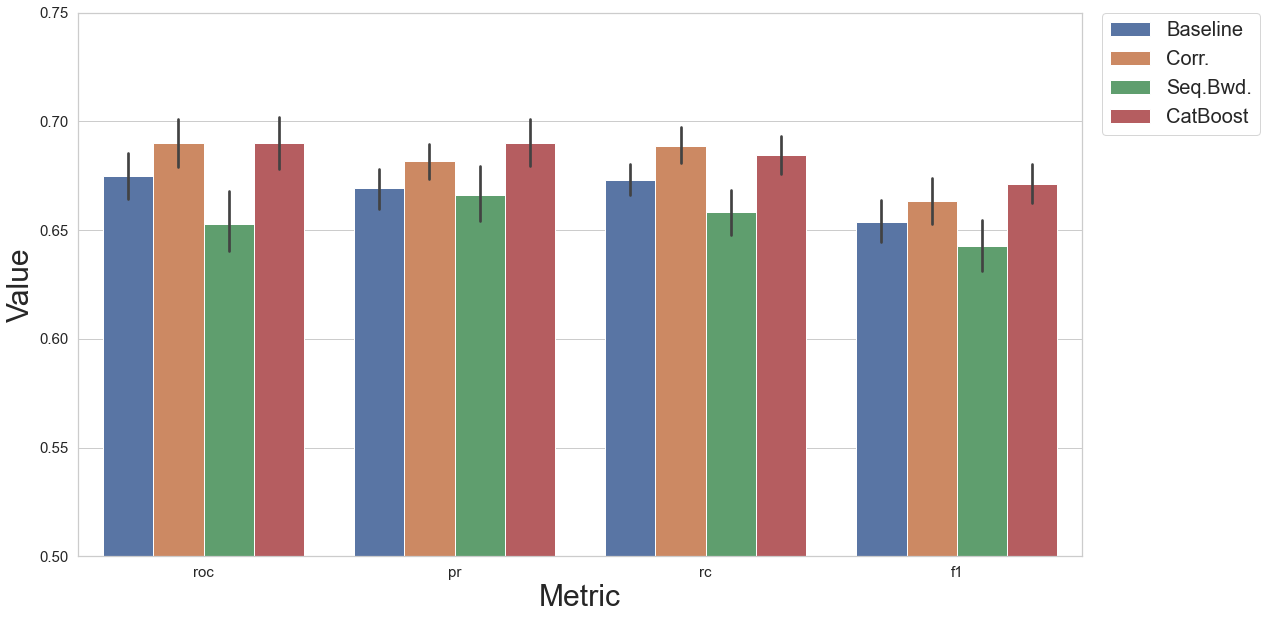

In [ ]:
plot_results(result_df)

### Artificial Instances - SMOTE

In [ ]:
result_base = test_base(df, label_col, N_EXEC, MODEL_NAME)
result_df = add_results_df(None, result_base, "Baseline")

restult_fs = test_smote(df, label_col, N_EXEC, MODEL_NAME, rcorr=True, art_str=0.7, under=False)
result_df = add_results_df(result_df, restult_fs, "SM")

restult_fs = test_smote(df, label_col, N_EXEC, MODEL_NAME, rcorr=True, art_str=0.7, under=True)
result_df = add_results_df(result_df, restult_fs, "SM+TK")

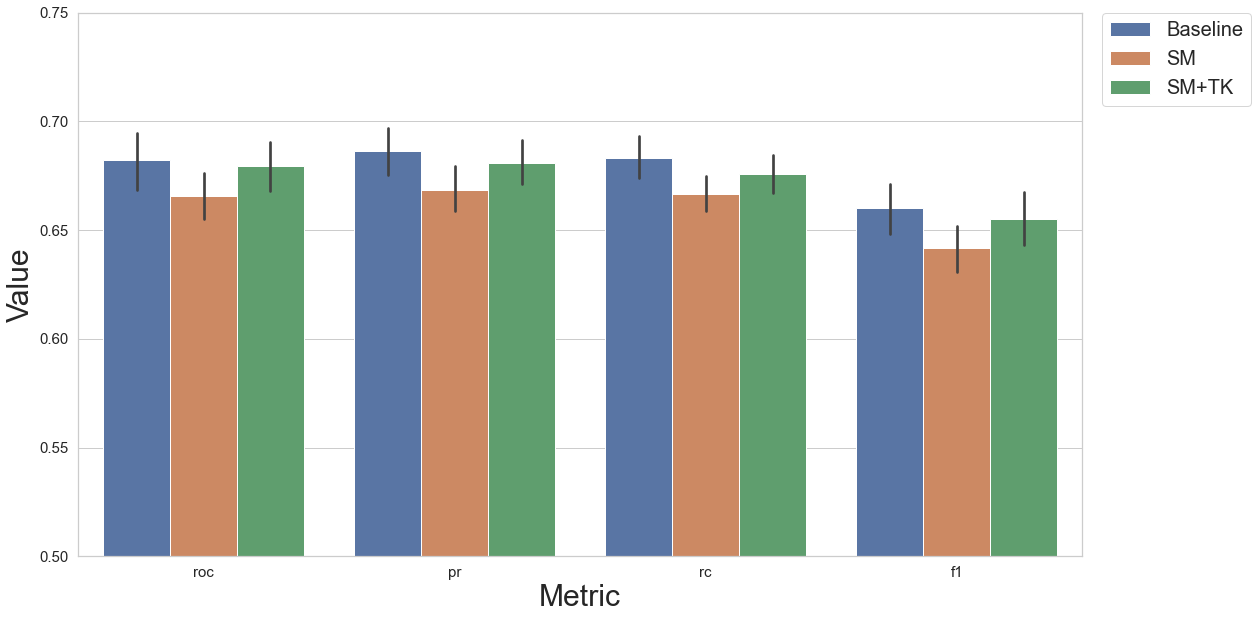

In [ ]:
plot_results(result_df)

### Artificial Instances - CTGAN

In [ ]:
result_base = test_base(df, label_col, N_EXEC, MODEL_NAME)
result_df = add_results_df(None, result_base, "Baseline")

restult_fs = test_ctgan_first(df, label_col, N_EXEC, MODEL_NAME, rcorr=False, feat_sel_type=None, art_str=0.6, savefile="1_3.pkl")
result_df = add_results_df(result_df, restult_fs, "CTGAN 0.6")

restult_fs = test_ctgan_first(df, label_col, N_EXEC, MODEL_NAME, rcorr=False, feat_sel_type=None, art_str=0.9, savefile="1_4.pkl")
result_df = add_results_df(result_df, restult_fs, "CTGAN 0.9")


/home/matheus/miniconda3/envs/resp/lib/python3.7/site-packages/sklearn/mixture/_base.py:146: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  .fit(X)
/home/matheus/miniconda3/envs/resp/lib/python3.7/site-packages/sklearn/mixture/_base.py:146: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  .fit(X)


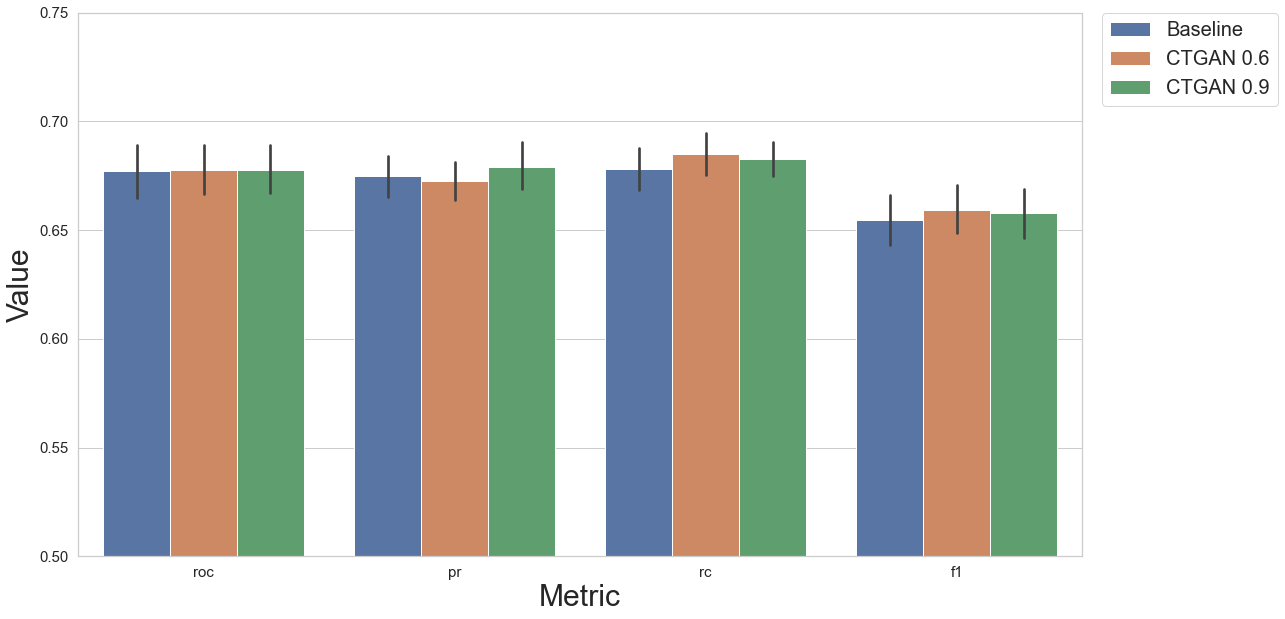

In [ ]:
plot_results(result_df)